In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")

### Read data

In [2]:
df = pd.read_csv("../data/raw/n.csv")
df["pub_date"] = pd.to_datetime(df["pub_date"])
df.drop(df.columns[:2], inplace=True, axis=1)
df.drop("6", inplace=True, axis=1)
df.set_index("pub_date", inplace=True)
# df["direction"] = df["5"] - df["1"]
# df["direction"] = df["direction"].apply(lambda x: 1 if x>=0 else 0)
df.head()

,actual,forecast,previous,rolling_std,z-score,1,5,7
pub_date,,,,,,,,
2008-03-27,-36,-33,-85,65.728090,-0.045643,1473.280029,1495.359985,0.052499
2008-04-03,-29,-34,-36,71.573018,0.069859,1497.920044,1453.439941,-0.028434
2008-04-10,-14,-15,-29,76.372839,0.013094,1579.839966,1550.400024,0.064580
2008-04-17,27,16,-14,86.497635,0.127171,1607.359985,1603.520020,0.033688
2008-04-24,24,22,27,76.112905,0.026277,1662.079956,1673.599976,0.042776


### Predictor variables: `actual`, `forecast`, `rolling_std`, `z-score` & `1` 

### Target variable: `7`

### `1`: open, `5`: close, `6`: volume, `7`: log difference between successive close

### Univariate visualisation of every feature

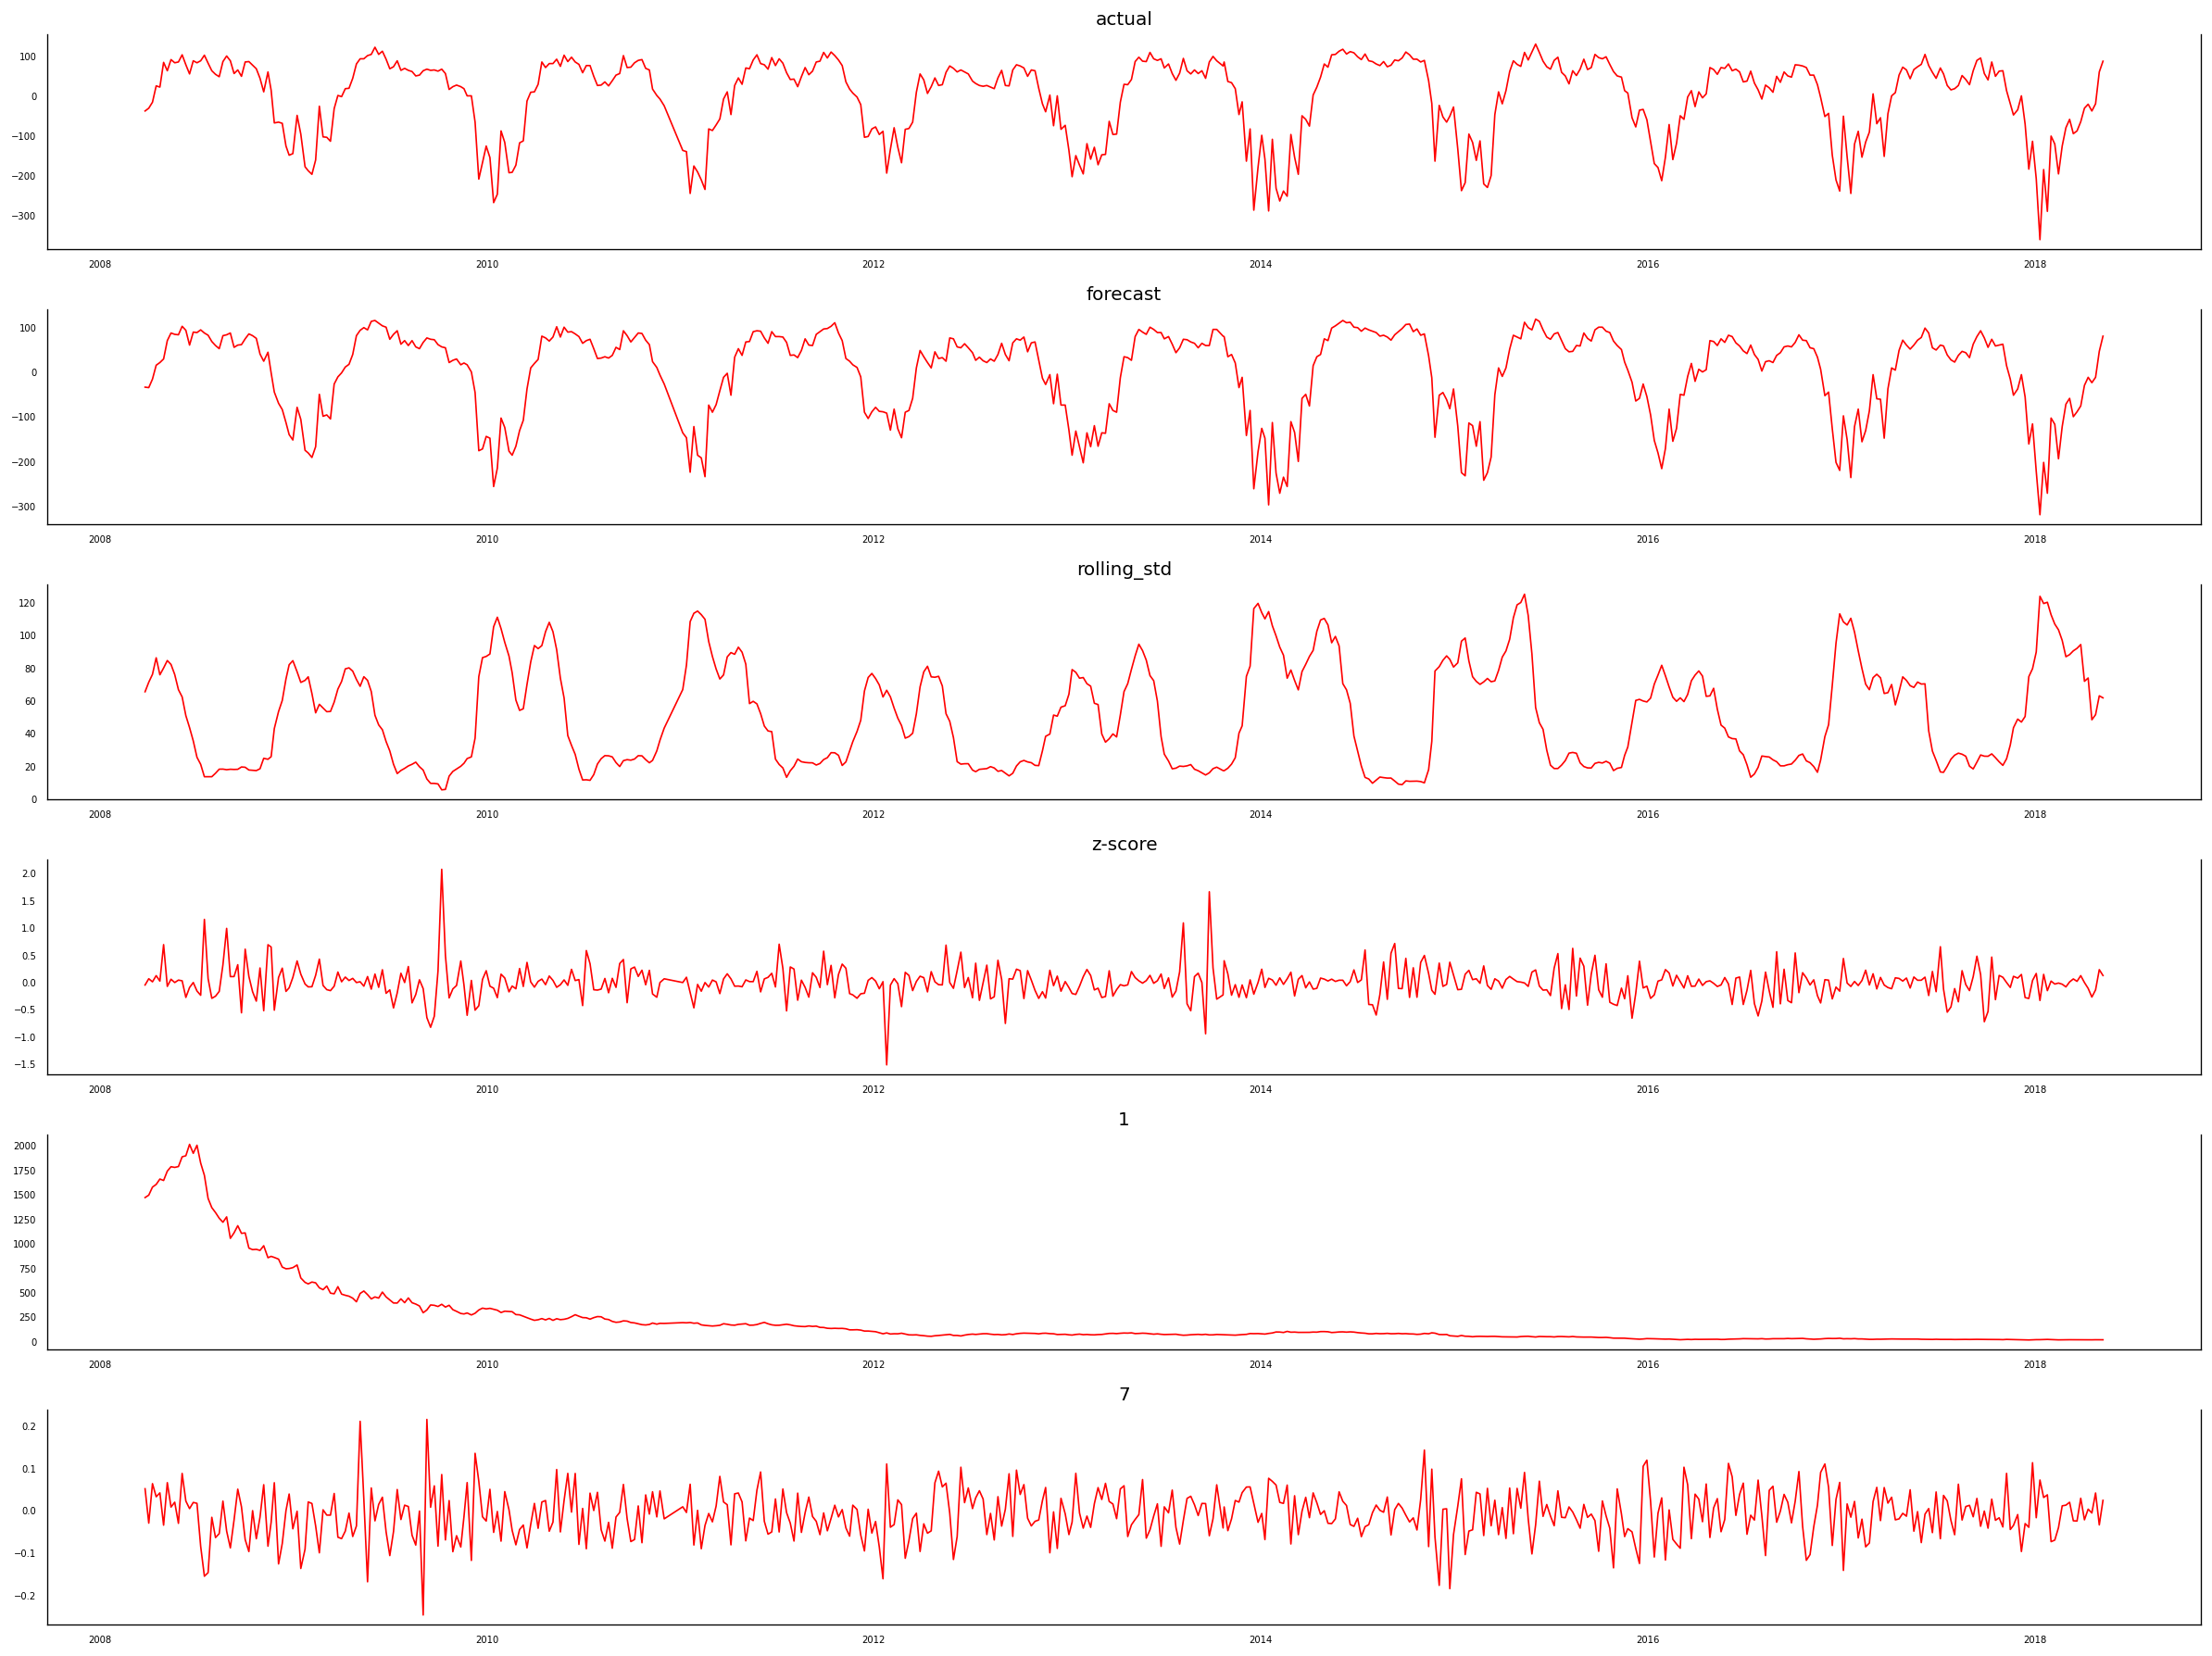

In [3]:
## Plot 

columns = ["actual", "forecast", "rolling_std", "z-score", "1", "7"]
fig, axes = plt.subplots(nrows=6, ncols=1, dpi=120, figsize=(20,15))
for i, ax in enumerate(axes.flatten()):
#     print(columns[i])
    data = df[columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Seasonality in: `actual` & `forecast` of **1 year**
### Trend in: `z-score`

### Step 1: Check for causality

Each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In [4]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = columns)

,actual_x,forecast_x,rolling_std_x,z-score_x,1_x,7_x
actual_y,1.0000,0.0001,0.0031,0.0083,0.3446,0.0043
forecast_y,0.0057,1.0000,0.0001,0.0143,0.4043,0.0005
rolling_std_y,0.0000,0.0000,1.0000,0.0776,0.2574,0.1523
z-score_y,0.7017,0.6919,0.5547,1.0000,0.0001,0.1114
1_y,0.7435,0.8116,0.0439,0.0084,1.0000,0.0000
7_y,0.2224,0.1183,0.3813,0.1973,0.0047,1.0000


### Step 2: Cointegration test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

In [5]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df[columns])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
actual ::  403.22    > 83.9383   =>   True
forecast ::  280.78    > 60.0627   =>   True
rolling_std ::  173.33    > 40.1749   =>   True
z-score ::  89.82     > 24.2761   =>   True
1      ::  41.06     > 12.3212   =>   True
7      ::  8.48      > 4.1296    =>   True


### Step 3: Check for stationarity of every feature

In [6]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [7]:
# ADF Test on each column
for col in columns:
    adfuller_test(df[col].values)
    print('\n')

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8819
 No. Lags Chosen       = 9
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9979
 No. Lags Chosen       = 9
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statisti

###  Step 4: Baseline Model

In [8]:
## Lag output by 1
df["7_1"] = df["7"].shift(1).fillna(0)

# separate into features and target
X = df[["actual", "forecast", "rolling_std", "z-score", "1", "7_1"]]
y = df["7"]

# separate into train & test
X_train, X_test = X.iloc[:int(0.8*len(X)),:], X.iloc[int(0.8*len(X)):,:]
y_train, y_test = y[:int(0.8*len(X))], y[int(0.8*len(X)):] 

# persistence model
def baseline_model(row):
    return row["7_1"]

# make predictions
preds = []
for idx, row in X_test.iterrows():
    pred = row["7_1"]
    preds.append(pred)
    
# evaluate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(y_test, preds), "MAE")
print(mean_squared_error(y_test, preds), "MSE")

0.05797302890137586 MAE
0.005133187440459932 MSE


In [9]:
correct = 0
for idx, val in enumerate(preds):
    original = y_test[idx]
    if (original >= 0) and (val >= 0):
        
        correct += 1
    elif (original < 0) and (val < 0):
        correct += 1
    else:
        pass

print("Accuracy", correct/len(y_test))

Accuracy 0.44761904761904764


### Step 5: Check for Autocorrelation

ACF for actual :


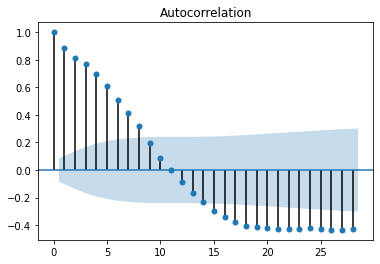

ACF for forecast :


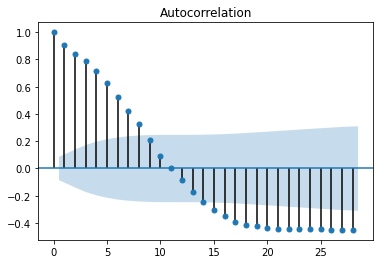

ACF for previous :


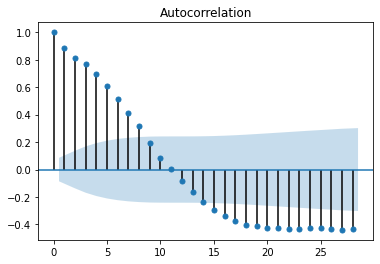

ACF for rolling_std :


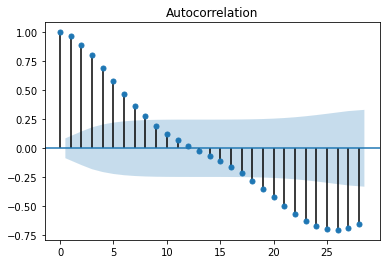

ACF for z-score :


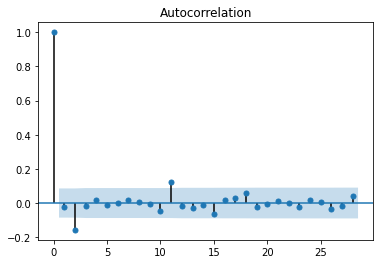

ACF for 1 :


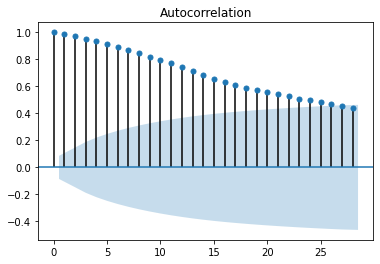

ACF for 5 :


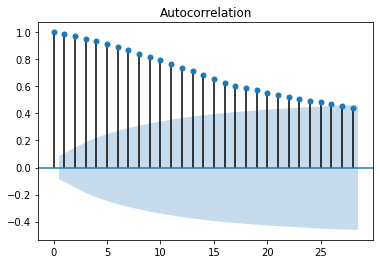

ACF for 7 :


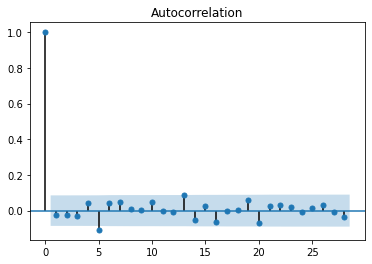

ACF for 7_1 :


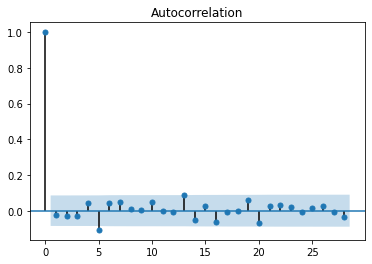

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

for col in df.columns:
    series = df[col]
    print("ACF for", col, ":")
    plot_acf(series)
    plt.show()

### Step 6: Create time lagged features for every predictor

In [11]:
df = df[columns]

for col in df.columns:
    lag_col_name = col + "_1"
    df[lag_col_name] = df[col].shift(1).fillna(0)
    
df.head()

,actual,forecast,rolling_std,z-score,1,7,actual_1,forecast_1,rolling_std_1,z-score_1,1_1,7_1
pub_date,,,,,,,,,,,,
2008-03-27,-36,-33,65.728090,-0.045643,1473.280029,0.052499,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2008-04-03,-29,-34,71.573018,0.069859,1497.920044,-0.028434,-36.0,-33.0,65.728090,-0.045643,1473.280029,0.052499
2008-04-10,-14,-15,76.372839,0.013094,1579.839966,0.064580,-29.0,-34.0,71.573018,0.069859,1497.920044,-0.028434
2008-04-17,27,16,86.497635,0.127171,1607.359985,0.033688,-14.0,-15.0,76.372839,0.013094,1579.839966,0.064580
2008-04-24,24,22,76.112905,0.026277,1662.079956,0.042776,27.0,16.0,86.497635,0.127171,1607.359985,0.033688


### Step 8: Train-test split

In [12]:
feature_cols = ["actual", "actual_1", "forecast", "forecast_1", "rolling_std", "rolling_std_1", "z-score", "z-score_1",
               "1", "1_1", "7_1"]

# split
X, y = df[feature_cols], df["7"]

# train-test split
X_train, X_test = X.iloc[:int(0.8*len(X)),:], X.iloc[int(0.8*len(X)):,:]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

In [13]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(420, 11) (105, 11)
(420,) (105,)


### Step 10: Outlier detection & treatment

In [14]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [15]:
for col in X_train.columns:
    series = X_train[col]
    ranges = outlier_treatment(series)
    print("Percentage of values as outliers for", col, "are: ")
    outliers = (series < ranges[0]) | (series > ranges[1])
    print(sum(outliers), len(series))
#     print(len(series) - sum(new_series))

Percentage of values as outliers for actual are: 
2 420
Percentage of values as outliers for actual_1 are: 
2 420
Percentage of values as outliers for forecast are: 
2 420
Percentage of values as outliers for forecast_1 are: 
2 420
Percentage of values as outliers for rolling_std are: 
0 420
Percentage of values as outliers for rolling_std_1 are: 
0 420
Percentage of values as outliers for z-score are: 
29 420
Percentage of values as outliers for z-score_1 are: 
29 420
Percentage of values as outliers for 1 are: 
50 420
Percentage of values as outliers for 1_1 are: 
50 420
Percentage of values as outliers for 7_1 are: 
9 420


#### Reducing impact of outliers using `RobustScaler`

In [16]:
from sklearn.preprocessing import RobustScaler

interest_cols = ["actual", "actual_1", "forecast", "forecast_1", "z-score", "z-score_1", "1", "1_1", "7_1"]
for col in interest_cols:
    scaler = RobustScaler()
    X_train.loc[:,col] = scaler.fit_transform(X_train[[col]])
    X_test.loc[:,col] = scaler.transform(X_test[[col]])

### Create two new new columns

In [17]:
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

# New column "year_even"
X_train["year_even"] = X_train["pub_date"].apply(lambda x:1 if x.year%2 else 0)
X_test["year_even"] = X_test["pub_date"].apply(lambda x:1 if x.year%2 else 0)

# New column "difference"
X_train["difference"] = X_train["actual"] - X_train["forecast"]
X_test["difference"] = X_test["actual"] - X_test["forecast"]

X_train.drop("pub_date", inplace=True, axis=1)
X_test.drop("pub_date", inplace=True, axis=1)

### Step 11: Check for important features using correlation plot (not removing any features)

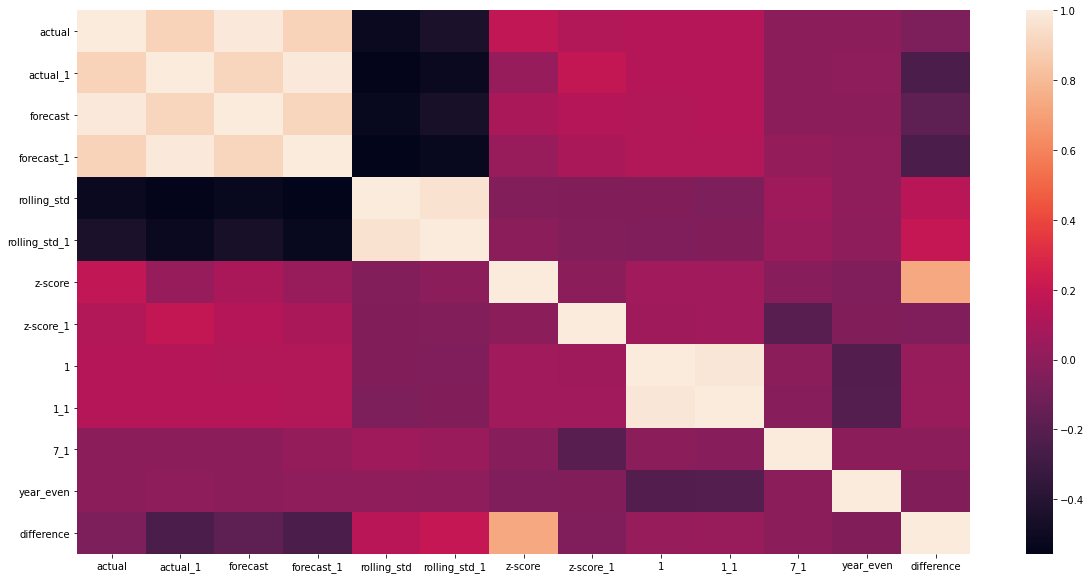

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.corr())
plt.show()

### Step 12: Train Linear Regression model

In [19]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_model_pred = linear_model.predict(X_test)
print("MSE is:", mean_squared_error(linear_model_pred, y_test))
print("MAE is:", mean_absolute_error(linear_model_pred, y_test))

MSE is: 0.0024907718871461436
MAE is: 0.03897280129889568


#### Residual Analysis

1. Residual vs Predicting Variable Plots ---> Independence of predictors
2. Residual vs Fitted Values ---> Homoscedasticity
3. Histogram & Q-Q plots ---> Normality of data generation

Column: actual


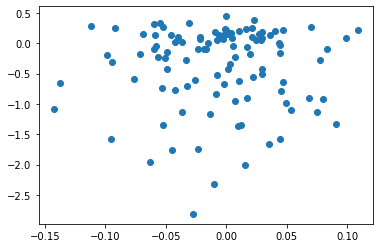

Column: actual_1


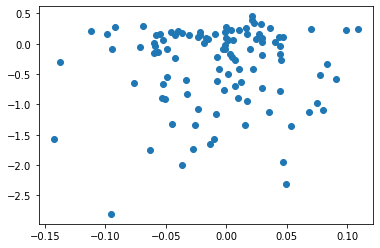

Column: forecast


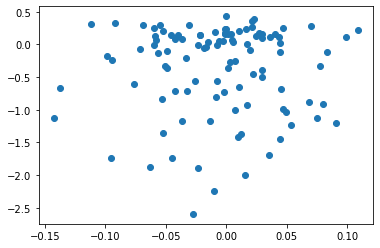

Column: forecast_1


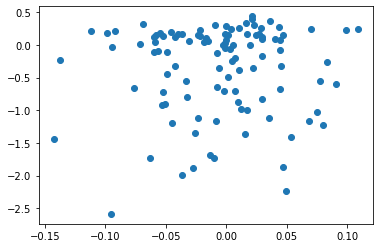

Column: rolling_std


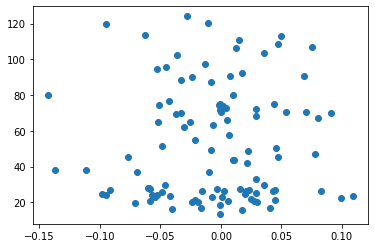

Column: rolling_std_1


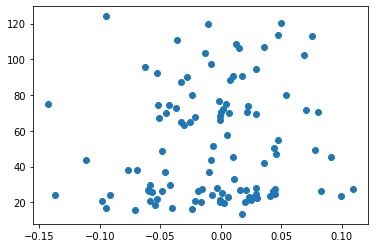

Column: z-score


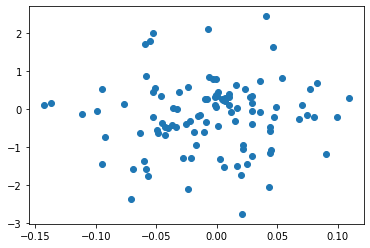

Column: z-score_1


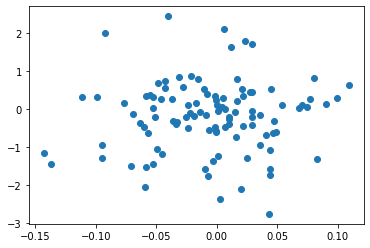

Column: 1


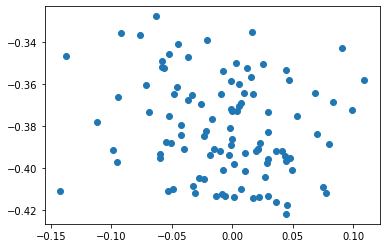

Column: 1_1


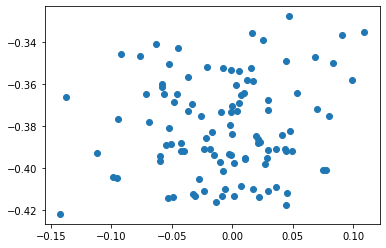

Column: 7_1


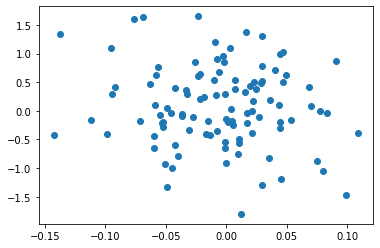

Column: year_even


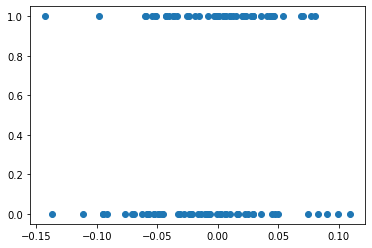

Column: difference


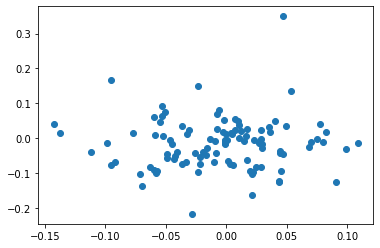

In [20]:
## 1. Residual vs Predicting Variable Plots

residuals = linear_model_pred - y_test.values

for col in X_test.columns:
    print("Column:", col)
    plt.scatter(residuals, X_test[col])
    plt.show()

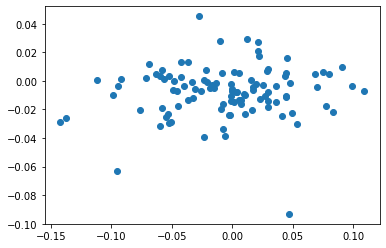

In [21]:
## 2. Residual vs Fitted Values

plt.scatter(residuals, linear_model_pred)
plt.show()

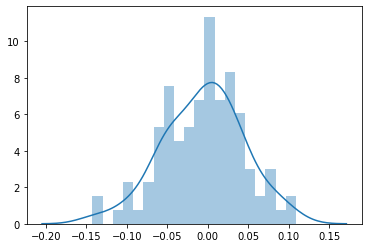

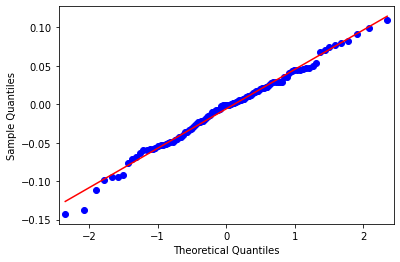

In [22]:
### 3. Histogram & Q-Q plot

import statsmodels.api as sm

# histogram
sns.distplot(residuals, bins=20)
plt.show()

# Q-Q plot
sm.qqplot(residuals, line="r")
plt.show()

In [23]:
## Feature importance
# get importance
importance = linear_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.07671
Feature: 1, Score: 0.08954
Feature: 2, Score: 0.07094
Feature: 3, Score: -0.08119
Feature: 4, Score: -0.00033
Feature: 5, Score: 0.00049
Feature: 6, Score: 0.00148
Feature: 7, Score: -0.00174
Feature: 8, Score: 0.03111
Feature: 9, Score: -0.03218
Feature: 10, Score: -0.00249
Feature: 11, Score: -0.00029
Feature: 12, Score: -0.14766


In [24]:
linear_model.coef_

array([-0.07671071,  0.08954461,  0.07094456, -0.08119262, -0.00032785,
        0.00048885,  0.00148352, -0.00174127,  0.03110931, -0.03217617,
       -0.00249117, -0.00028874, -0.14765527])

In [25]:
X_train.head()

,actual,actual_1,forecast,forecast_1,rolling_std,rolling_std_1,z-score,z-score_1,1,1_1,7_1,year_even,difference
0,-0.549912,-0.290718,-0.526316,-0.279492,65.728090,0.000000,-0.209681,-0.037317,7.418578,-0.533492,0.103105,0,-0.023597
1,-0.500876,-0.542907,-0.533575,-0.519056,71.573018,65.728090,0.226497,-0.209681,7.551573,7.418578,0.817360,0,0.032700
2,-0.395797,-0.493870,-0.395644,-0.526316,76.372839,71.573018,0.012130,0.226497,7.993738,7.551573,-0.283740,0,-0.000153
3,-0.108581,-0.388792,-0.170599,-0.388385,86.497635,76.372839,0.442931,0.012130,8.142279,7.993738,0.981719,0,0.062017
4,-0.129597,-0.101576,-0.127042,-0.163339,76.112905,86.497635,0.061914,0.442931,8.437631,8.142279,0.561436,0,-0.002555


### Step 13: Train Decision Tree, Random Forest with & without regularization

In [26]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor(random_state=42, criterion="mae", max_depth=5, max_features="log2")
decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)
print("MAE", mean_absolute_error(decision_tree_pred, y_test))
print("MSE", mean_squared_error(decision_tree_pred, y_test))

MAE 0.03969499825777561
MSE 0.0024235168617263102


In [27]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(random_state=42, n_estimators=200, criterion="mae", max_features="log2")
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)
print("MAE", mean_absolute_error(random_forest_pred, y_test))
print("MSE", mean_squared_error(random_forest_pred, y_test))

MAE 0.040357394227531825
MSE 0.002520123530237628


In [28]:
## Feature importance of random forest
pd.DataFrame(random_forest.feature_importances_, index = X_train.columns,
                    columns=['importance']).sort_values('importance', ascending=False)

,importance
z-score,0.113641
difference,0.105254
z-score_1,0.090389
7_1,0.088004
1_1,0.087225
1,0.086570
rolling_std,0.079553
rolling_std_1,0.075618
actual_1,0.067992
forecast,0.066657


In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boost = GradientBoostingRegressor(criterion="mae", random_state=42)
gradient_boost.fit(X_train, y_train)
gradient_boost_pred = gradient_boost.predict(X_test)
print("MAE", mean_absolute_error(gradient_boost_pred, y_test))
print("MSE", mean_squared_error(gradient_boost_pred, y_test))

MAE 0.03754881267997595
MSE 0.0022176428947137832


### Task 2: Predicting direction

In [30]:
models = [linear_model_pred, decision_tree_pred, random_forest_pred, gradient_boost_pred]

for model in models:
    correct = 0
    for idx, val in enumerate(model):
        original = y_test[idx]
        if (original >= 0) and (val >= 0):

            correct += 1
        elif (original < 0) and (val < 0):
            correct += 1
        else:
            pass

    print("Accuracy",  correct/len(y_test))

Accuracy 0.6476190476190476
Accuracy 0.6666666666666666
Accuracy 0.5238095238095238
Accuracy 0.5523809523809524


In [31]:
linear_model_pred

array([ 0.00745068, -0.00147397, -0.00963125,  0.00064639,  0.01162026,
       -0.01983222, -0.00703381,  0.00737661, -0.0102718 , -0.01075098,
       -0.00417945,  0.00173444, -0.0077921 , -0.02199179,  0.00013627,
        0.00159504, -0.03392569,  0.00568632, -0.01928535, -0.00058043,
       -0.00284939, -0.02941817,  0.00116171, -0.02004504, -0.00701748,
       -0.00326121, -0.00763186, -0.00284498, -0.00382172, -0.02627801,
       -0.0207303 ,  0.00957832, -0.0177523 ,  0.0045201 , -0.09308751,
        0.02905646,  0.00073377, -0.01364343,  0.00504064, -0.00917545,
       -0.03047897,  0.00495518, -0.02862718,  0.0129844 , -0.02409951,
        0.00308003, -0.00694742, -0.00081905, -0.01372387, -0.01334096,
       -0.00595502, -0.00798394,  0.01339417, -0.01831932, -0.00247956,
       -0.00403476, -0.00734532,  0.0274061 , -0.0149395 ,  0.00250613,
       -0.02447895, -0.00345804,  0.00030464, -0.00253205, -0.01136555,
        0.00328056, -0.02408419, -0.00489121, -0.0052399 , -0.01